# # methyl cluster aware model

In [16]:
%load_ext autoreload
%autoreload 2 

import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
# how to use matrixfactory in pineapple
# https://github.com/freenome/research/blob/master/docs/data_access_tutorial.ipynb


# import poisson model components
# an example pineapple experiment yaml
# https://github.com/freenome/pineapple/tree/master/pineapple/experiments/dc1/methyl

from pineapple.contrib.components.transformers.methyl import ChoseSettingsAndRegionsForPoisson, PoissonOutlier

from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import auc, confusion_matrix
from sklearn.metrics import plot_roc_curve  # need pip install scikit-learn==0.22.1
from sklearn.model_selection import StratifiedKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from pineapple.contrib.utils.stats.statistical_tests import specificity_thresholds
from sklearn import metrics

In [2]:
# define defaults for choosing regions to use
# pulled from here??: https://github.com/freenome/pineapple/blob/fcbe2a3717cde1cb03d3da8def055401e8f5429c/pineapple/contrib/specs/transformer_specs.py#L513

chooser = ChoseSettingsAndRegionsForPoisson(min_stage_or = 4.0,
                                                    min_effect_size = 5.0,
                                                    min_tumor_size_mm_or = 35.0,
                                                    pessimistic_effect_size_ci = 0.95,
                                                    low_noise_cutoff_percentile_per_region = 90.0,
                                                    min_prob_clean = 0.75,
                                                    desired_noise_floor = 1 / 50000,
                                                    use_minimal_noise_floor_no_obs = False,
                                                    minimal_noise_floor_with_no_obs = 1 / 1000,
                                                    use_fold_change = True,
                                                    use_all_samples_effect_size = False,
                                                    include_case_samples_with_use_public_assay_data = False,
                                                    case_class_label = 1,
                                                    min_features = 2,
                                                    )

poiss_model = PoissonOutlier(desired_noise_floor =1 / 50000,
                                 standardize_to_mean_healthies = True,
                                 output_count = False,
                                 pseudo_count = 1.0,
                                 max_hmf_rate_healthy = 1/ 5000,
                                 min_features = 2)

In [3]:
from collections import Counter

In [63]:
def viz_clust2(mat_clust, labels=None):
    '''
    Arg: matrix factory matrix
    '''
    # heatmap of pct methylation values across crc samples
    # values at 3cpgs
    clust1_data = mat_clust[:,:,0,:]
    
    # remove regions where there is no coverage in most samples
    df_tot = pd.DataFrame(clust1_data.x[...,1])
    def my_func(col):
        return np.sum(col > 0) >= 5
    reg_to_keep = df_tot.apply(my_func, axis=0)
    #print(reg_to_keep)
    clust1_data = clust1_data[:,reg_to_keep,:]
    assert clust1_data.shape[1]>0, "Sparse data"
    
    clust1_rates = pd.DataFrame(clust1_data.x[...,0] / clust1_data.x[...,1])
    clust1_rates = clust1_rates.fillna(clust1_rates.mean(axis=0))
    #print(clust1_rates.head())
    print(f"clust_rates is NA: {clust1_rates.isna().sum().sum()}")

    if labels is None:
        crcs = [lbl==1 for lbl in mat_clust1.y]
    else:
        crcs = [lbl=="Colorectal Cancer" for lbl in labels]
    
    #print(crcs)
    clust1_rates_crc = clust1_rates[crcs]
    assert clust1_rates_crc.shape[0] != 0

    
    ## get MSI status 

    sid_to_msi = {}
    for i, d in enumerate(mat_clust.dataset_metadata):
        msi = d.raw_sample_metadata['lims_msi']['tumor_msi_status']
        #ctype = d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"]
        if msi == 'Unavailable':
            msi = None
        sid_to_msi[mat_clust.sample_ids[i]]= msi
    #Counter(sid_to_msi.values())

    msis_crcs = [sid_to_msi[sid] for sid in mat_clust[crcs].sample_ids]
    msi_colors = [ "red" if msi=="MSS" else "blue" for msi in msis_crcs]
    
    tumor_locs = [d.raw_sample_metadata['lims_top_diagnosis']['lesion_location'] for d in mat_clust[crcs].sample_metadata]
    tumor_loc_col_dict = {'Ascending colon (right)':"green", #proximal
                          'Hepatic flexure':"green", #proximal
                          'Ileocecal valve': "green", #proximal
                          'Cecum': "green",
                          'Rectum':"orange", #distal
                          'Sigmoid colon':"orange", #distal
                          'Splenic flexure': "orange", #distal
                          'Rectosigmoid': "orange",
                          'Descending colon (left)':'orange', #distal
                          'Transverse colon': "white",
                           None: "white"}
    tumor_locs_colors = [tumor_loc_col_dict[loc] for loc in tumor_locs]
    
    
    plt.figure()
    cg = sns.clustermap(clust1_rates_crc,
                  row_cluster=True, col_cluster=True,
                  yticklabels=True,
                  xticklabels=False,
                  row_colors=msi_colors,
                  figsize=(10,10))
    cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram

    # heatmap of masked pct methylation values across crc samples
    df_mask_clust1_reg, clust1_feature = get_k2_clust_score(clust1_data)
    #print(df_mask_clust1_reg.head())
    #print(clust1_feature)
    plt.figure()
    #plt.hist(clust2_feature[crcs], bins=15)
    plt.scatter(range(len(clust1_feature[crcs])), sorted(clust1_feature[crcs]))

    print(df_mask_clust1_reg[crcs].head())
    plt.figure()
    cg = sns.clustermap(df_mask_clust1_reg[crcs],
                 row_cluster=True, col_cluster=True,
                 metric='hamming',
                 yticklabels=True,
                 xticklabels=False,
                 row_colors= [msi_colors,
                              tumor_locs_colors,
                             ],
                 figsize=(10,10))
    cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram


In [9]:
tumor_locs = [d.raw_sample_metadata['lims_top_diagnosis']['lesion_location'] for d in mat_clust.sample_metadata]
Counter(tumor_locs)

Counter({'Ascending colon (right)': 26,
         'Cecum': 21,
         None: 115,
         'Transverse colon': 18,
         'Rectum': 28,
         'Sigmoid colon': 28,
         'Ileocecal valve': 4,
         'Descending colon (left)': 13,
         'Hepatic flexure': 6,
         'Rectosigmoid': 3,
         'Splenic flexure': 2})

## Prediction using TCGA Regions from consensus clustering

In [5]:
# import cluster defining regions
#classes = ['colorectal_cancer_targetmethyl1_discovery1h']

classes = ['colorectal_healthy_targetmethyl1_discovery1h',
            'colorectal_cancer_targetmethyl1_discovery1h',
            'colorectal_precancer_targetmethyl1_discovery1h',
            'colorectal_benign_targetmethyl1_discovery1h',
            'colorectal_healthy_targetmethyl1_discovery1h_panelofneg']

class_labels=[0,1,0,0,0]

mat_clust = mf.create_from_training_classes(classes,
                                            'hmfc_tcga_cluster_regions_k2/v2',
                                            class_labels)

print(mat_clust.x.shape)
mat_clust.x[0:5,0:5,0,1]

(264, 82, 31, 2)


array([[ 494,  554,  430, 1451, 2433],
       [ 528,  581,    4, 1361, 2630],
       [ 458,  488,  487, 1375, 2262],
       [ 494,  525,    5, 1277, 2871],
       [ 483,  489,    6, 1487, 2457]], dtype=uint16)

In [6]:
Counter(mat_clust.y)

Counter({1: 49, 0: 215})

In [7]:
# separate cluster regions into one group from cluster 1 and one for cluster 2
reg_to_keep = [d["cluster"]==0 for d in mat_clust.column_metadata] ## this is the non-cimp crc group
mat_clust1 = mat_clust[:,reg_to_keep,...]
print(mat_clust1.x.shape)

reg_to_keep = [d["cluster"]==1 for d in mat_clust.column_metadata] ## this is the cimp3/4 ccluster group
mat_clust2 = mat_clust[:,reg_to_keep,...]
print(mat_clust2.x.shape)

Counter(mat_clust2.y)

(264, 23, 31, 2)
(264, 59, 31, 2)


Counter({1: 49, 0: 215})

In [8]:
# import 434 region datasets
classes = ['colorectal_healthy_targetmethyl1_discovery1h',
            'colorectal_cancer_targetmethyl1_discovery1h',
            'colorectal_precancer_targetmethyl1_discovery1h',
            'colorectal_benign_targetmethyl1_discovery1h',
            'colorectal_healthy_targetmethyl1_discovery1h_panelofneg',]

#class_labels=["Healthy","Cancer","Pre_Cancer","Benign","PoN"]
class_labels=[0,1,0,0,0]
mat_434 = mf.create_from_training_classes(classes,
                                          'hyper_methylated_fragment_count_by_min_methyl_cpgs_per_region/v5',
                                           class_labels)

print(mat_434.x.shape)

Counter(mat_434.y)




(264, 434, 31, 2)


Counter({1: 49, 0: 215})

In [70]:
# a function to run standard cross validation on log reg model looiking at poisson probabilities
# REF: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

np.random.seed(0)

classifier = LogisticRegression(C=10,
                             penalty='none',
                             max_iter=2000,
                             solver="lbfgs",
                             class_weight="balanced")
 
def cross_validate(X, y):
    cv = StratifiedKFold(n_splits=5)  # balanced by class
    tprs = []
    aucs = []
    coefs = []
    cv_calls = {}
    cv_scores = {}
    mean_fpr = np.linspace(0, 1, 100) # 100 numbers evenly split between 0 and 1
    fig, ax = plt.subplots(figsize=(10,10))
    for i, (train, test) in enumerate(cv.split(X,y)):  #two sets of indexes for splitting
        classifier.fit(X[train], y[train])
        coefs.append(classifier.coef_)
        
        test_labels = classifier.predict(X[test]) # each sample occurs only once as a test sample
        test_calls = dict(zip(test, test_labels))
        test_scores = dict(zip(test, [ x[1] for x in classifier.predict_log_proba(X[test])])) # list of probability CRC
        cv_calls.update(test_calls)
        cv_scores.update(test_scores)

        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)   # returns obj of class sklearn.metrics.RocCurveDisplay
        # return tpr values at theoretical cumulative fpr values from 0 to 1 linear interp for cumulative fpr vs. cum tpr, 10 vals ea
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr) # calc auc using points x=mean_fprs, y=mean tprs across folds
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f"Mean ROC (AUC = {np.round(mean_auc,2)} +/- {np.round(std_auc,3)})",
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1) # set vals plus 1 stdev > 1 to =1
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0) # set vals minus 1 stdev < 0 to =0
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label='+/- 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    
    #find sens at 90 spec
    print(len(cv_scores.keys()))
    print(len(X))
    thresh_low, thresh_hi = specificity_thresholds(y, [cv_scores[sample_idx] for sample_idx in range(X.shape[0])], 0.90)
    cv_score_list = [cv_scores[sample_idx] for sample_idx in range(X.shape[0])]
    predict_new = [1 if score > thresh_hi else 0 for score in cv_score_list]
    val = metrics.precision_score(y, predict_new)
    print(f"Sensitivity at 90% Spec.: {round(val,3)}")
    
    # conf matrix of cross-val calls
    assert len(cv_calls.keys()) == len(X), "There should be one cv call per sample in the data set"
    print("Confusion Matrix")
    cm = pd.DataFrame(confusion_matrix(y, [cv_calls[sample] for sample in range(len(X))]))
    cm.columns = ["pred.0", "pred.1"]
    cm.index = ["true.0", "true.1"]
    print(cm)
    
    
    return coefs


(264, 60, 2)
(264, 1)
264
264
Sensitivity at 90% Spec.: 0.857
Confusion Matrix
        pred.0  pred.1
true.0     210       5
true.1       7      42


[array([[11.11747333]]),
 array([[12.44308428]]),
 array([[10.98145029]]),
 array([[12.04427921]]),
 array([[11.78616077]])]

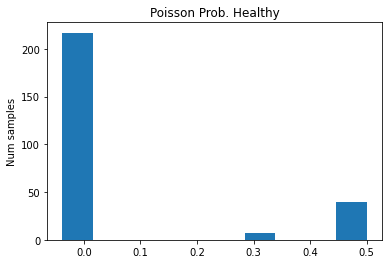

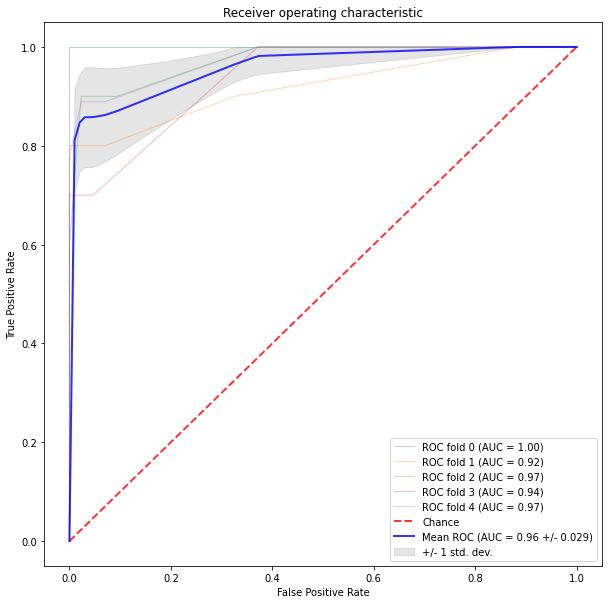

In [71]:
# Run cross validation using standard modeling regions

selected_regions = chooser.fit(mat_434).transform(mat_434)
print(selected_regions.x.shape)

poiss_probs = poiss_model.fit(selected_regions).transform(selected_regions) # returns Matrix
print(poiss_probs.x.shape) 
plt.figure()
plt.title("Poisson Prob. Healthy")
plt.ylabel("Num samples")
plt.hist(poiss_probs.x)

cross_validate(poiss_probs.x, poiss_probs.y)

# an issue with the tumor_size metadata to fix . . .

In [52]:
# Create a simple feature out of the tcga cluster defining regions

# a crc-cluster comethylation score. A feature that increaes if a sample looks like the cluster signatures we see in CRC tissue. 
# The percent of cluster-defining regions that have methylation above healthy average/noise floor

def get_k2_clust_score(matrix):
    '''
    Args:
        matrix: a samples x regions x (meth_counts, total_counts). already filtered at the learned/chosen CpG
        cutoff for each region
    '''
    if len(matrix.x.shape) > 3:
        mat_data = matrix.x[:,:,0,:]  # for now use the 3 cpg threshold
    else:
        mat_data = matrix.x
        
    # FIT
    print(f"input matrix {matrix.x.shape}")
    control_samples = mat_data[matrix.y == 0]
    assert control_samples.shape[0] >= 2, "Too few control samples for fit." 
    
    # for each region the sum of all meth reads and the sum of total reads across samples
    # a matrix (regions x (tot_meth_counts, tot_total_counts))
    control_for_mean_fit = np.sum(control_samples, axis=0)
    assert [x > 0 for x in control_for_mean_fit[...,1]], "there is a region with no reads in any sample" 

    # calc mean pct methylation for each region 
    reg_mean_in_healthies = np.maximum(poiss_model.desired_noise_floor, 
                               control_for_mean_fit[..., 0] / control_for_mean_fit[..., 1])
    
    # using the max pct meth in healthies as a threshold returns tumor fraction signal
    #control_rates = control_samples[...,0] / control_samples[...,1]
    #reg_max_pct_meth = np.amax(control_rates, 0)
    #print(f"reg_max_pct_meth shape {reg_max_pct_meth.shape}")
    
    # TRANSFORM
    #print(f"rate matrix shape {(matrix.x[...,0] / matrix.x[...,1]).shape}")
    matrix_rates = pd.DataFrame((mat_data[...,0] / mat_data[...,1]))
    print(f"Imputing NaNs: {matrix_rates.isna().sum().sum()}")
    # impute regions with no data as the mean methylation rate
    matrix_rates = matrix_rates.fillna(matrix_rates.mean(axis=0))   #### I think some of these means are coming out as NA
    print(f"NaNs: {matrix_rates.isna().sum().sum()}")
    
    # mask regions as above or below the methylation rate in healthies
    mask_list = []
    nregions = matrix_rates.shape[1]
    n_imputed = 0 
    
    for col_idx in range(nregions):        
        vals = [1 if x >= reg_mean_in_healthies[col_idx] else 0 for x in matrix_rates[col_idx]]
        #vals = [1 if x > reg_max_pct_meth[col_idx] else 0 for x in matrix_rates[col_idx]]
        mask_list.append(vals)
    df_matrix_masked = pd.DataFrame(mask_list).T
    print(f"masked matrix of rates: {df_matrix_masked.shape}")
    #print(df_matrix_masked.head())
    
    # this feature is the percentage of cluster-defining regions that are methylated above the healthy mean 
    feature = df_matrix_masked.apply(lambda x: np.sum(x)/float(nregions), axis=1)
    
    return df_matrix_masked, np.array(feature)



clust_rates is NA: 0
input matrix (264, 23, 2)
Imputing NaNs: 7
NaNs: 0
masked matrix of rates: (264, 23)
    0   1   2   3   4   5   6   7   8   9   ...  13  14  15  16  17  18  19  \
0    1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   0   
1    1   0   0   0   1   1   1   1   1   1  ...   1   0   1   0   1   1   1   
5    0   1   0   0   0   1   1   1   1   0  ...   1   0   1   1   1   1   0   
15   0   0   1   1   1   1   1   1   1   1  ...   1   1   1   1   0   1   1   
25   0   1   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   0   

    20  21  22  
0    1   0   0  
1    1   1   1  
5    1   1   1  
15   1   1   1  
25   0   0   1  

[5 rows x 23 columns]


<Figure size 432x288 with 0 Axes>

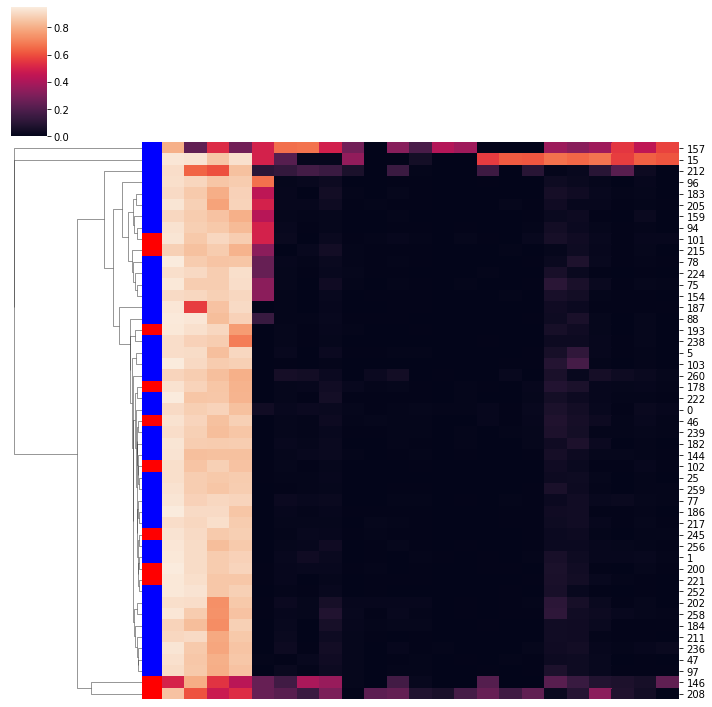

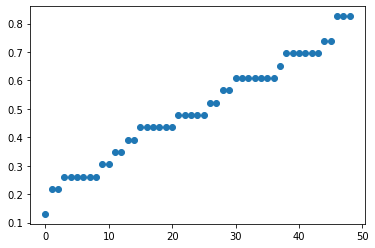

<Figure size 432x288 with 0 Axes>

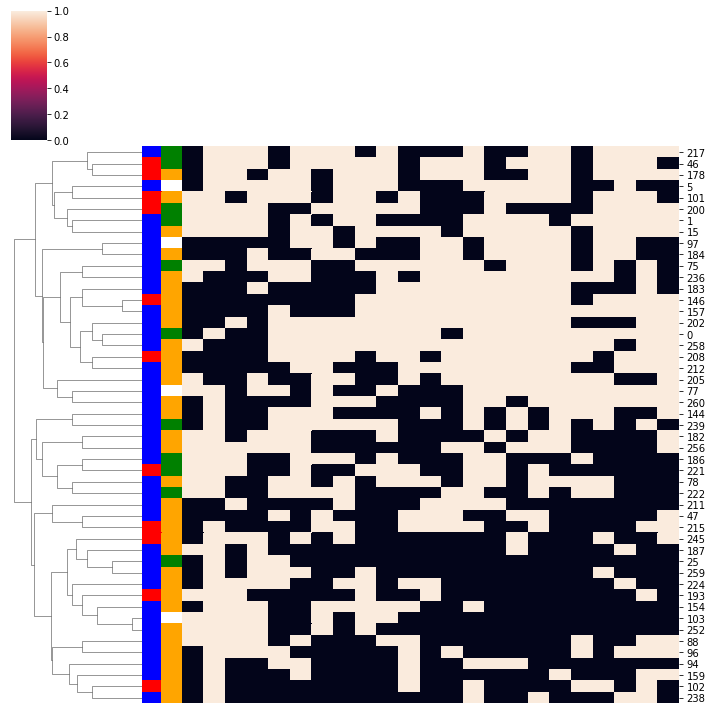

In [64]:
# Visualize Cluster-1 defining regions (CIMP H/L crc groups)
viz_clust2(mat_clust1)



clust_rates is NA: 0
input matrix (264, 55, 2)
Imputing NaNs: 0
NaNs: 0
masked matrix of rates: (264, 55)
    0   1   2   3   4   5   6   7   8   9   ...  45  46  47  48  49  50  51  \
0    1   1   0   1   1   0   0   0   1   1  ...   1   0   0   1   0   1   1   
1    0   0   0   1   0   0   0   0   1   0  ...   1   1   0   0   1   0   0   
5    1   1   0   0   0   0   0   0   0   1  ...   1   0   0   0   1   0   0   
15   1   1   1   1   1   1   0   0   1   0  ...   1   1   1   0   0   1   1   
25   0   0   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   0   

    52  53  54  
0    0   1   1  
1    0   0   1  
5    1   1   1  
15   1   0   0  
25   0   0   0  

[5 rows x 55 columns]


<Figure size 432x288 with 0 Axes>

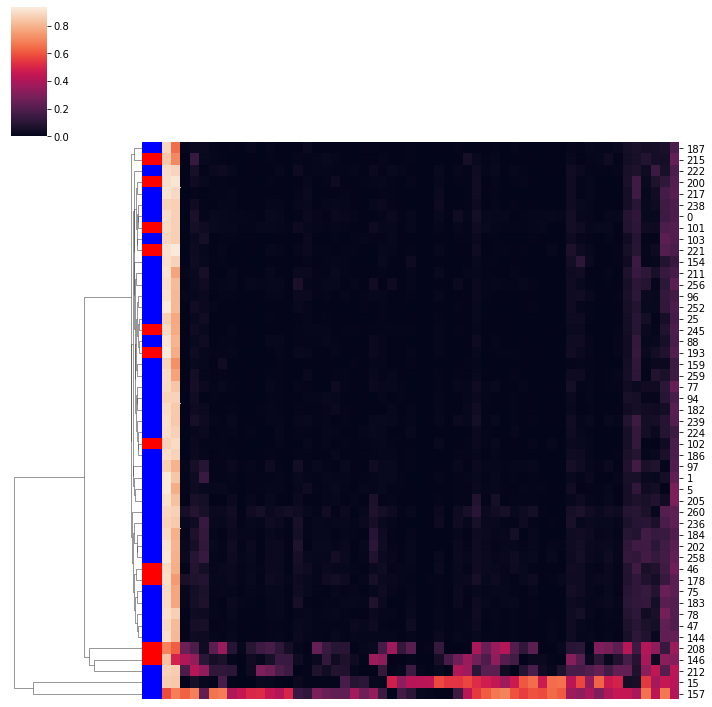

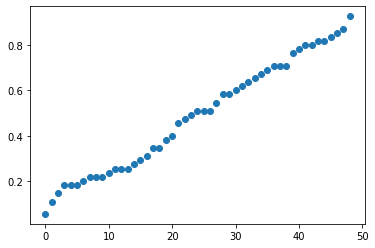

<Figure size 432x288 with 0 Axes>

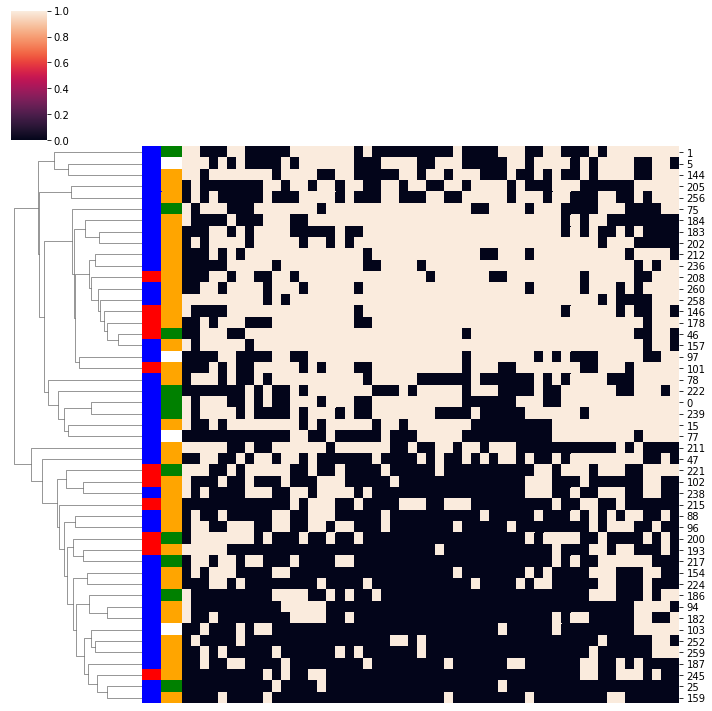

In [66]:
# Visualize Cluster-2 defining regions (CIMP 3/4 group, non-cimp CRC)
viz_clust2(mat_clust2)



In [78]:
# Cluster 2 regions
# incorporate %cluster_regions feature into the crc prediciton model
selected_regions = chooser.fit(mat_434).transform(mat_434)
print(selected_regions.x.shape)

poiss_probs = poiss_model.fit(selected_regions).transform(selected_regions) # returns Matrix
print(poiss_probs.x.shape) 
#plt.figure()
#plt.title("Poisson Prob. Healthy")
#plt.ylabel("Num samples")
#plt.hist(poiss_probs.x)

df_mask, clust2_feature = get_k2_clust_score(mat_clust2)



(264, 60, 2)
(264, 1)
input matrix (264, 59, 31, 2)
Imputing NaNs: 1056
NaNs: 1056
masked matrix of rates: (264, 59)


(264, 2)
(264, 2)
264
264
Sensitivity at 90% Spec.: 0.677
Confusion Matrix
        pred.0  pred.1
true.0     210       5
true.1       7      42
[array([[11.07801179,  0.90030559]]), array([[12.350498  ,  0.62512683]]), array([[10.90992002,  1.97826012]]), array([[12.05589552, -0.07418502]]), array([[11.69938426,  1.01026505]])]


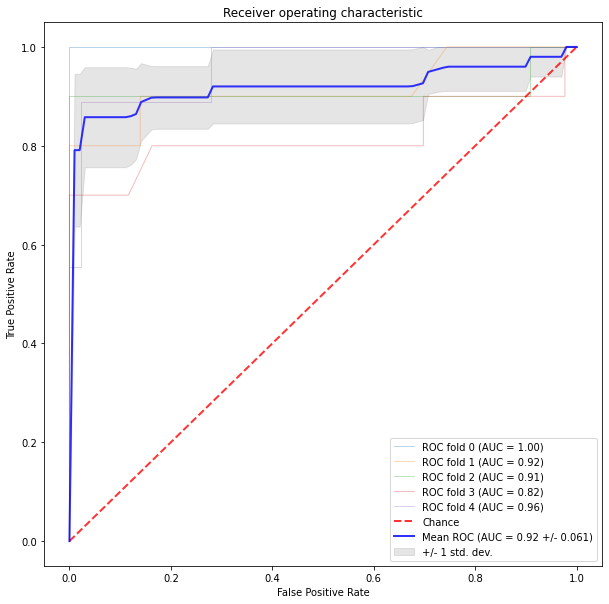

In [73]:
df_poiss_probs = pd.DataFrame(poiss_probs.x)
df_poiss_probs["clust2"] = [x for x in clust2_feature]
print(df_poiss_probs.shape)
df_poiss_probs.head()

combo_data = np.array(df_poiss_probs)
print(df_poiss_probs.shape)
coeficients = cross_validate(combo_data, poiss_probs.y)
print(coeficients) # coeffs learned for each fold 

In [76]:
# Cluster 1 regions
# incorporate %cluster_regions feature into the crc prediciton model
selected_regions = chooser.fit(mat_434).transform(mat_434)
print(selected_regions.x.shape)

poiss_probs = poiss_model.fit(selected_regions).transform(selected_regions) # returns Matrix
print(poiss_probs.x.shape) 
#plt.figure()
#plt.title("Poisson Prob. Healthy")
#plt.ylabel("Num samples")
#plt.hist(poiss_probs.x)

df_mask, clust1_feature = get_k2_clust_score(mat_clust1)



(264, 60, 2)
(264, 1)
input matrix (264, 23, 31, 2)
Imputing NaNs: 7
NaNs: 0
masked matrix of rates: (264, 23)


(264, 2)
(264, 2)
264
264
Sensitivity at 90% Spec.: 0.689
Confusion Matrix
        pred.0  pred.1
true.0     210       5
true.1       7      42
[array([[11.13179958, -0.13659473]]), array([[12.43634859,  0.03205207]]), array([[10.79349649,  1.51958066]]), array([[12.23333415, -0.88853198]]), array([[11.8126829 , -0.13152697]])]


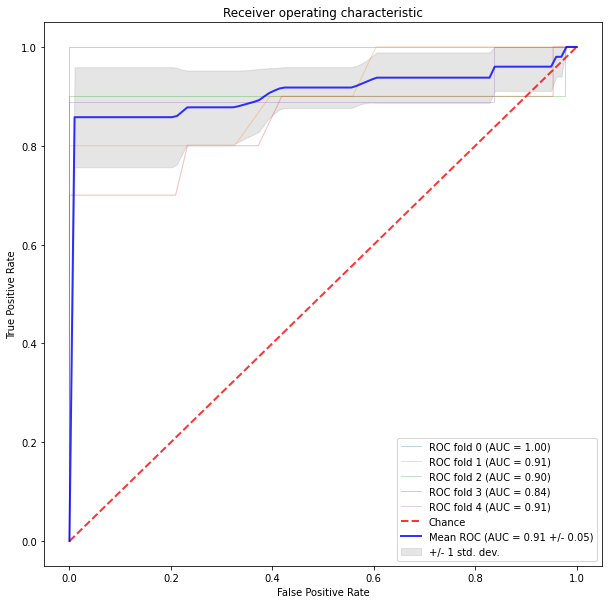

In [77]:
df_poiss_probs = pd.DataFrame(poiss_probs.x)
df_poiss_probs["clust2"] = [x for x in clust1_feature]
print(df_poiss_probs.shape)
df_poiss_probs.head()

combo_data = np.array(df_poiss_probs)
print(df_poiss_probs.shape)
coeficients = cross_validate(combo_data, poiss_probs.y)
print(coeficients)

## Prediction using non-CIMP markers from analysis of HM27 TCGA cimp labeled samples

In [79]:
# import cluster defining regions
#classes = ['colorectal_cancer_targetmethyl1_discovery1h']

classes = ['colorectal_healthy_targetmethyl1_discovery1h',
            'colorectal_cancer_targetmethyl1_discovery1h',
            'colorectal_precancer_targetmethyl1_discovery1h',
            'colorectal_benign_targetmethyl1_discovery1h',
            'colorectal_healthy_targetmethyl1_discovery1h_panelofneg']

class_labels=[0,1,0,0,0]

mat_clust = mf.create_from_training_classes(classes,
                                            'hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region/v4',
                                            class_labels)

print(mat_clust.x.shape)


#matrix
#(samples, regions, thresholds, (methyl_counts, total_counts))
mat_clust.x[0:5,0:5,0,1]

MATRIX FACTORY: 3 of 264 feature vectors are missing from 'hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region/v4'


(264, 13, 1, 2)


array([[1554.,  805.,  428.,    0., 3186.],
       [1792.,  790.,  462.,    0., 3882.],
       [1559.,  721.,  449.,    0., 3472.],
       [1469.,  675.,  458.,    0., 4090.],
       [1602.,  694.,  436.,    0., 3518.]])

In [81]:
# ok just manually remvoe them after trying for a day to get these 3 to summarize 
from featureio import FeatureIO

classes = ['colorectal_healthy_targetmethyl1_discovery1h',
            'colorectal_cancer_targetmethyl1_discovery1h',
            'colorectal_precancer_targetmethyl1_discovery1h',
            'colorectal_benign_targetmethyl1_discovery1h',
            'colorectal_healthy_targetmethyl1_discovery1h_panelofneg']

dsids = []
with FeatureIO() as ftio:
    for cls in classes:
        dsids.extend(ftio.get_datasets_for_training_class(cls))

len(dsids)




264

In [82]:
for id in ("SD-000049DA","SD-000049B7","SD-00004925"):
    dsids.remove(id)
len(dsids)

261

In [85]:
mat_clust = mf.create_from_dataset_ids(dataset_ids=dsids, feature_str='hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region/v4',
                                      dataset_labels=new_labels,
                                      ) # read in as pair!!!
print(mat_clust.shape)

dsid_to_ctype = {}
for i,d in enumerate(mat_clust.sample_metadata):
    dsid = mat_clust.dataset_ids[i]
    ctype = d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"]
    dsid_to_ctype[dsid]=ctype

labels = [dsid_to_ctype[dsid] for dsid in dsids]
new_labels = [1 if lb=="Colorectal Cancer" else 0 for lb in labels]

(261, 13, 1, 2)


In [86]:
## check that the labeling worked above!!!
#a = [1,1,1]
#b = [1,1,1]
a=mat_clust.y
b=[ d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"] for d in mat_clust.sample_metadata]
b = [1 if lb=="Colorectal Cancer" else 0 for lb in b]
print(a[0:10])
print(b[0:10])

assert all([a==b for a,b in zip(a,b )])


[1 1 0 0 0 1 0 0 0 0]
[1, 1, 0, 0, 0, 1, 0, 0, 0, 0]


In [16]:
# dont need to do this if mat_434 was already created above
mat_434 = mf.create_from_dataset_ids(dataset_ids=dsids, 
                                     feature_str='hyper_methylated_fragment_count_by_min_methyl_cpgs_per_region/v5',
                                    dataset_labels=new_labels
                                    )
print(mat_434.shape)

labels = [dsid_to_ctype[dsid] for dsid in dsids]
#new_labels = [1 if lb=="Colorectal Cancer" else 0 for lb in labels]

Counter(mat_434.y)


Experiment context not set, defaulting experiment_timestamp to 2020-03-12 00:40:00


(261, 434, 31, 2)


Counter({'Colorectal Cancer': 49,
         'Colorectal Normal / Healthy': 110,
         'Colorectal Pre-Cancer': 59,
         'Unclassifiable': 1,
         'Colorectal Benign': 42})

In [91]:
# separate cluster regions into one group from cluster 3/4 and one for cluster CIMP

# CIMP cluster
reg_to_keep = [d["cluster"]=='0' for d in mat_clust.column_metadata] 
mat_clust_noncimp = mat_clust[:,reg_to_keep,...]
print(mat_clust1.x.shape)

# non-CIMP cluster
reg_to_keep = [d["cluster"]=='1' for d in mat_clust.column_metadata] 
mat_clust_cimp = mat_clust[:,reg_to_keep,...]
print(mat_clust2.x.shape)



(261, 3, 1, 2)
(261, 10, 1, 2)


In [19]:
## get MSI status 
'''
incorporated into viz_clusters2 above
kept here for reference


sid_to_msi = {}
for i, d in enumerate(mat_clust.dataset_metadata):
    msi = d.raw_sample_metadata['lims_msi']['tumor_msi_status']
    #ctype = d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"]
    if msi == 'Unavailable':
        msi = None
    sid_to_msi[mat_clust.sample_ids[i]]= msi
Counter(sid_to_msi.values())

# all samples are MSS that are CRC with status at all.
#msss = [ sid_to_msi[sid]=="MSS" for sid in mat_clust.sample_ids]
#ctypes = [ d.raw_sample_metadata['lims_top_diagnosis']['cancer_type'] for d in mat_clust[msss].sample_metadata ]
#print(ctypes)

Counter({None: 250, 'MSS': 11})

clust_rates is NA: 0
input matrix (261, 3, 2)
Imputing NaNs: 0
NaNs: 0
masked matrix of rates: (261, 3)
    0  1  2
0   1  1  1
1   1  1  0
5   1  0  1
14  0  0  1
23  0  1  0


<Figure size 432x288 with 0 Axes>

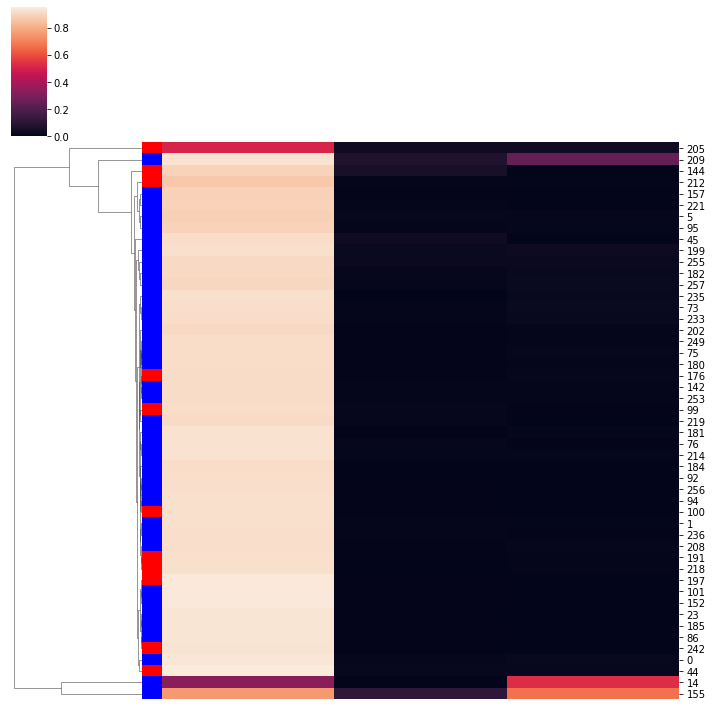

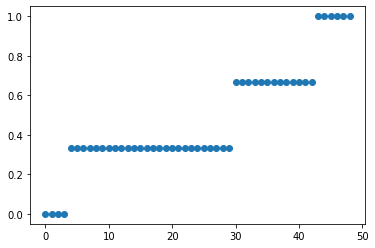

<Figure size 432x288 with 0 Axes>

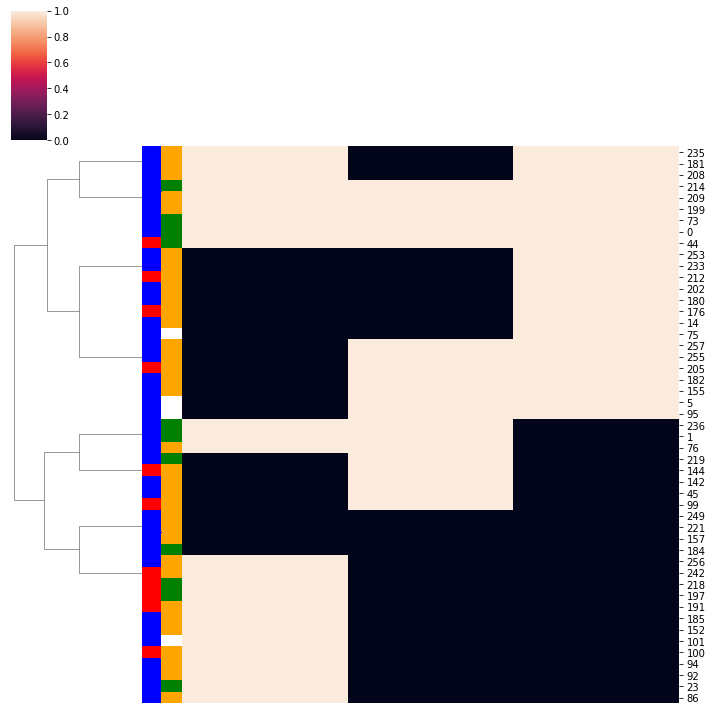

In [88]:
# Visualize Cluster-1 defining regions (this is the CIMP.H+CIMP.L cluster markers from the paper)
viz_clust2(mat_clust_noncimp)



clust_rates is NA: 0
input matrix (261, 9, 2)
Imputing NaNs: 0
NaNs: 0
masked matrix of rates: (261, 9)
    0  1  2  3  4  5  6  7  8
0   0  1  1  1  1  0  1  1  1
1   0  0  1  1  1  1  0  0  1
5   1  1  1  1  0  1  1  1  1
14  1  1  1  1  0  1  1  0  1
23  0  0  0  0  0  0  0  0  0


<Figure size 432x288 with 0 Axes>

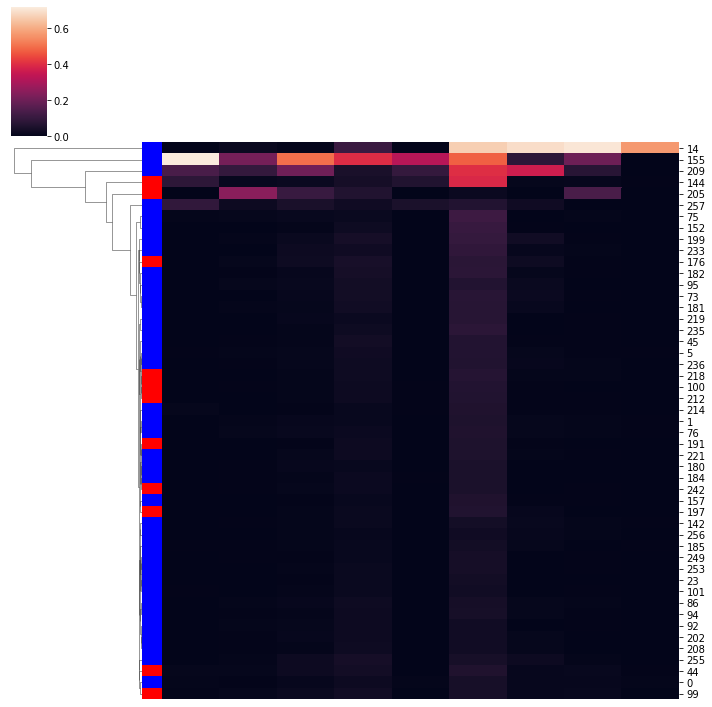

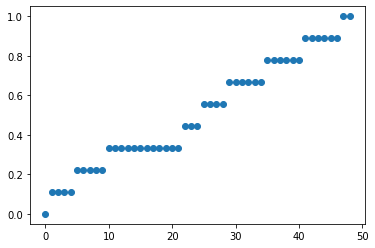

<Figure size 432x288 with 0 Axes>

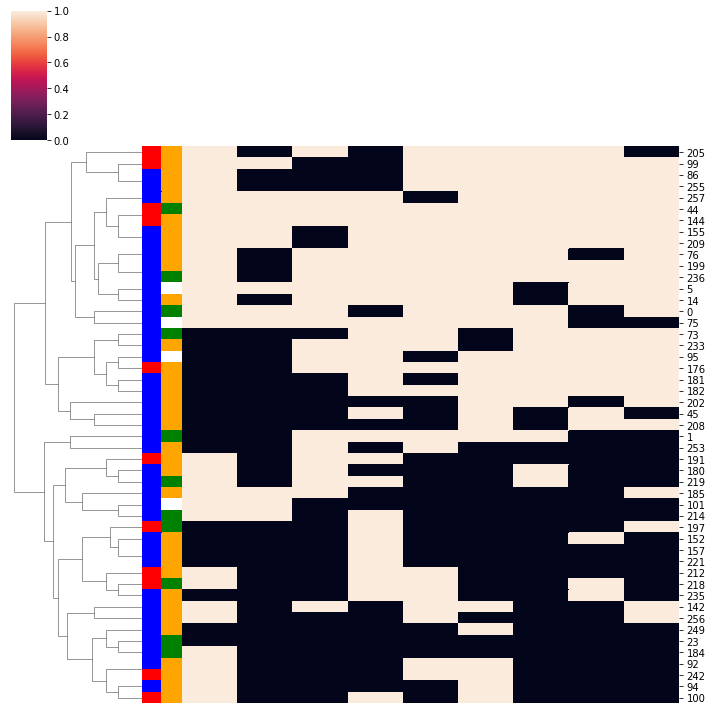

In [89]:
# Visualize Cluster-2 defining regions (this is the cluster3+4 markers from the paper (non-cimp))
viz_clust2(mat_clust_cimp)



In [94]:
# Cluster CIMP regions
# incorporate %cluster_regions feature into the crc prediciton model
selected_regions = chooser.fit(mat_434).transform(mat_434)
print(selected_regions.x.shape)

poiss_probs = poiss_model.fit(selected_regions).transform(selected_regions) # returns Matrix
print(poiss_probs.x.shape) 
#plt.figure()
#plt.title("Poisson Prob. Healthy")
#plt.ylabel("Num samples")
#plt.hist(poiss_probs.x)

df_mask, clust_cimp_feature = get_k2_clust_score(mat_clust_cimp)



(264, 60, 2)
(264, 1)
input matrix (261, 10, 1, 2)
Imputing NaNs: 260
NaNs: 0
masked matrix of rates: (261, 10)


(261, 2)
261
261
Sensitivity at 90% Spec.: 0.689
Confusion Matrix
        pred.0  pred.1
true.0     207       5
true.1       7      42
[array([[10.93782754,  1.09661599]]), array([[12.1934188 ,  1.01926427]]), array([[10.65760488,  1.08231246]]), array([[11.84292289,  0.67735886]]), array([[11.50536955,  1.7042222 ]])]


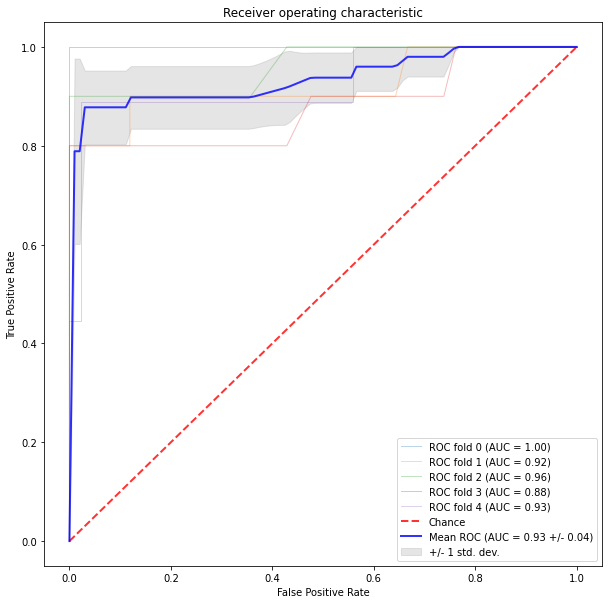

In [104]:
df_poiss_probs = pd.DataFrame(poiss_probs.x)

sid_to_clust_score = dict(zip(mat_clust_cimp.sample_ids, clust_cimp_feature))

avail_sids = [(sid in mat_clust_cimp.sample_ids) for sid in mat_434.sample_ids]
mat_434_available =  mat_434[avail_sids]

poiss_probs_labels = poiss_probs.y[avail_sids]
df_poiss_probs = df_poiss_probs[avail_sids]
df_poiss_probs["clust_cimp"] = [sid_to_clust_score[sid] for sid in mat_434_available.sample_ids]

print(df_poiss_probs.shape)
df_poiss_probs.head()

combo_cimp = np.array(df_poiss_probs)
#print(df_poiss_probs.shape)
coeficients = cross_validate(combo_cimp, poiss_probs_labels)
print(coeficients)

In [106]:
# Cluster non-CIMP regions
# incorporate %cluster_regions feature into the crc prediciton model
selected_regions = chooser.fit(mat_434).transform(mat_434)
print(selected_regions.x.shape)

poiss_probs = poiss_model.fit(selected_regions).transform(selected_regions) # returns Matrix
print(poiss_probs.x.shape) 
#plt.figure()
#plt.title("Poisson Prob. Healthy")
#plt.ylabel("Num samples")
#plt.hist(poiss_probs.x)

df_mask, clust_noncimp_feature = get_k2_clust_score(mat_clust_noncimp)




(264, 60, 2)
(264, 1)
input matrix (261, 3, 1, 2)
Imputing NaNs: 0
NaNs: 0
masked matrix of rates: (261, 3)


(261, 2)
261
261
Sensitivity at 90% Spec.: 0.724
Confusion Matrix
        pred.0  pred.1
true.0     207       5
true.1       7      42
[array([[11.08702002,  0.07272021]]), array([[12.40749954,  0.14909356]]), array([[10.94412074,  0.56952531]]), array([[12.05591239, -0.49535227]]), array([[11.74939834,  0.38078239]])]


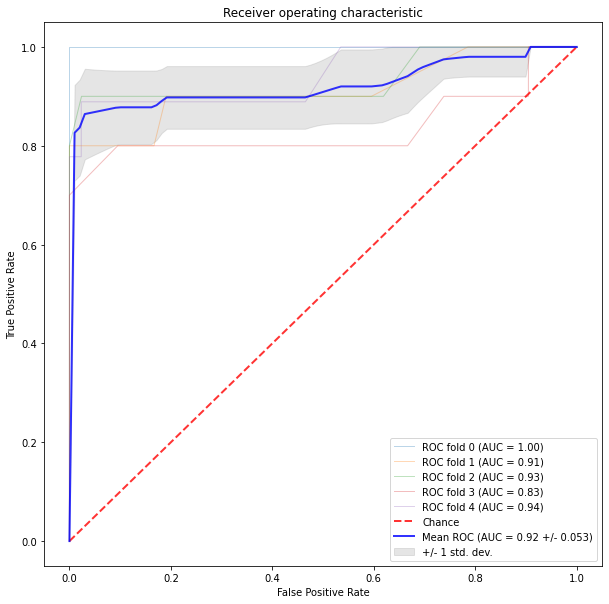

In [107]:
df_poiss_probs = pd.DataFrame(poiss_probs.x)

sid_to_clust_score = dict(zip(mat_clust_noncimp.sample_ids, clust_noncimp_feature))

avail_sids = [(sid in mat_clust_noncimp.sample_ids) for sid in mat_434.sample_ids]
mat_434_available =  mat_434[avail_sids]

poiss_probs_labels = poiss_probs.y[avail_sids]
df_poiss_probs = df_poiss_probs[avail_sids]
df_poiss_probs["clust_noncimp"] = [sid_to_clust_score[sid] for sid in mat_434_available.sample_ids]

print(df_poiss_probs.shape)
df_poiss_probs.head()

combo_noncimp = np.array(df_poiss_probs)
#print(df_poiss_probs.shape)
coeficients = cross_validate(combo_noncimp, poiss_probs_labels)
print(coeficients)

### Avenio results deck: https://docs.google.com/presentation/d/1OlCjby5f6O9B_AQTGg8BAIihJJt9YDNSGq39LVD6_iQ/edit#slide=id.g5b94e37312_0_387

In [ ]:
# what is going on in the poisson outlier transformer
class PoissonOutlier(Transformer):
    __spec_cls__ = PoissonOutlierSpec

    standardize_to_n: Optional[float]
    features_to_keep: np.ndarray
    means_healthy: np.ndarray

    @classmethod
    def from_spec(cls, spec: PoissonOutlierSpec) -> PoissonOutlier:
        return cls(**spec["kwargs"])

    def __init__(
        self,
        desired_noise_floor: float,
        standardize_to_mean_healthies: bool,
        output_count: bool,
        pseudo_count: float,
        max_hmf_rate_healthy: float,
        min_features: int,
    ):
        """ Given a samples x regions x (n hypermethyl, n total) counts input, this function transforms the counts into
            a mean centered global rate. This assumes that each region has it's own background rate of hypermethylation
            (learned from healthy samples) which is at least set to the desired_noise_floor. We then calculate the
            poisson probability that the observed rate in a sample is greater than the expected rate in the healthy
            given each regions expected noise level, and observed coverage level.
        Args:
            desired_noise_floor: noise floor in healthy samples to shoot for
            standardize_to_mean_healthies: Remove differential coverage effects in the output probabilities.
            pseudo_count: pseudo-count to add in for mean calculation, discounts regions with low counts
            output_count: just output the count and skip the poisson part
            max_hmf_rate_healthy: maximum observed HMF for region inclusion
            min_features: minimum number of features to include, chose best by lowest hmf rate in healthy.
        """
        self.desired_noise_floor = desired_noise_floor
        self.pseudo_count = pseudo_count
        self.min_features = min_features
        self.too_high_mean = max_hmf_rate_healthy
        self.standardize_to_mean_healthies = standardize_to_mean_healthies
        self.output_count = output_count

        self.standardize_to_n = None
        self.features_to_keep = None
        # resets the feature for healthies, setting the value to be max(desired, observed means)
        self.means_healthy = None

    def fit(self, matrix: Matrix) -> PoissonOutlier:
        """ Fits the background expectation over
        Args:
            matrix: matrix to fit on
        Returns:
        """
        control_samples = matrix.x[matrix.y == 0]
        assert control_samples.shape[0] >= 2, "Too few control samples for fit."
        control_for_mean_fit = np.sum(control_samples, axis=0)

        # Set the observed mean values to the maximum of the desired noise floor and the per-region observed mean
        # mean rate in healthy samples = total meth counts / total counts OR noise floor
        self.means_healthy = np.maximum(
            self.desired_noise_floor,
            (control_for_mean_fit[..., 0] + self.pseudo_count) / (control_for_mean_fit[..., 1] + self.pseudo_count),
        )

        # return the indices of the N=self.min_features lowest mean rates among regions within healthies
        bottom_n_means = np.argsort(self.means_healthy)[: self.min_features]  # best min_features by probability

        # set True, features below the noise cutoff for mean methylation
        self.features_to_keep = self.means_healthy < self.too_high_mean
        # set also True the N features with the lowest noise in healthies
        self.features_to_keep[bottom_n_means] = True  # set the best n to true as well as ones that pass cutoff
        
        # for each control sample calc the total number of frags across feat_to_keep
        # find the 10th percentile value of total frag sums
        # return the percentile or 1.0 if value is empty
        if self.standardize_to_mean_healthies:
            self.standardize_to_n = max(
                np.percentile(np.sum(control_samples[:, self.features_to_keep], axis=1)[..., 1], 10,), 1.0,
            )

        return self

    def transform(self, matrix: Matrix) -> Matrix:
        """ 
        Actually, return poisson probabilities of healthy given learned self.means_healthy 
        and self.features_to_keep in the fit
        """
        expected_prop_clean = self.means_healthy[self.features_to_keep]
        counts_clean = matrix.x[..., self.features_to_keep, 1]
        observed_clean = matrix.x[..., self.features_to_keep, 0]
        total_observed_clean = np.sum(observed_clean, axis=-1)
        expected_counts_clean = counts_clean * expected_prop_clean # expected num meth frags = total counts * meth rate in healthy
        total_reads = np.sum(counts_clean, axis=-1)
        # the expected total num meth frags across all kept regions
        expected_count_clean = np.sum(expected_counts_clean, axis=-1)  # the poisson expectation

        # create conversion factors that standardize to the 10th percentile of total frag counts 
        if self.standardize_to_n is not None:
            conversion_factors = self.standardize_to_n / total_reads
        else:
            conversion_factors = 1.0
            
        # across samples, return the poisson prob of healthy given total meth counts obsv across all regions
        if self.output_count:
            result = total_observed_clean * conversion_factors
        else:
            result = (
                poisson.cdf(total_observed_clean * conversion_factors, expected_count_clean * conversion_factors,)
                - 0.5,
            )  # center cdf at 0 
        
        return matrix.replace_x_and_axis_metadata(
            x=np.reshape(result, newshape=(matrix.x.shape[0], 1)),
            axis_metadata=(matrix.row_metadata, np.array([{"name": "poisson_outlier_score"}]),),
        )